In [1]:
import os
from pathlib import PosixPath
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from collections import OrderedDict

tqdm.pandas(ncols=50)

## Data preparation

In [22]:
df = None

for path in [
    'data/trained3_payloads_extreme_low_speed_1000traj/*.csv',
    # 'data/trained3_num_cassie_50kg_1000traj/*.csv',
    # 'data/trained3_num_cassie_50_only_1000traj/*.csv',
]:

    assert len(glob.glob(path)) > 0, f'No files found for {path}'

    for file in glob.glob(path):
        df_ = pd.read_csv(file, index_col=0)

        if df is None:
            df = df_
        else:
            # Merge rows
            df = pd.concat([df, df_], ignore_index=True)


def extend_columns(x):
    run_args = eval(x['run_args'])

    res = dict(
        command_x=run_args['command']['x'],
        command_y=run_args['command']['y'],
        command_t=run_args['command']['t'],
        command_h=run_args['command']['h'],
        terrain=run_args['env']['terrain'],
        force=run_args['env']['force'],
        policy=run_args['env']['policy'],
    )

    total_power = 0
    for i, power in enumerate(list(map(float, x['power'][1:-1].split()))):
        res[f'power_{i}'] = power
        total_power += power

    res['power'] = total_power

    joint_forces = []
    for i, joint_force in enumerate(list(map(float, x['joint_forces'][1:-1].split()))):
        res[f'joint_forces_{i}'] = joint_force
        joint_forces.append(joint_force)

    res['joint_forces'] = np.mean(joint_forces)

    res['perturbation_force_start'], res['perturbation_force_end'] \
        = map(int, x['perturbation_force_bound'][1:-1].split(','))

    res['perturbation_force_window'] = res['perturbation_force_end'] - res['perturbation_force_start']

    total_height_diff = 0
    for i, height_diff in enumerate(list(map(float, x['height_diff'][1:-1].split()))):
        res[f'height_diff_{i}'] = height_diff
        total_height_diff += height_diff

    res['height_diff'] = total_height_diff

    return res


df = pd.concat([df.progress_apply(lambda x: pd.Series(extend_columns(x)), axis=1), df], axis=1)
df = df.loc[:, ~df.columns.duplicated()]

df.columns.duplicated().any()

100%|█████| 11000/11000 [00:04<00:00, 2749.24it/s]


False

In [23]:
df.num_cassie.unique()

array([100,  25,  50])

In [110]:
x = df[(df.policy == 'trained_3_torque_joint_force_randomize_weight') & (df.force == 0) & (df.episode_length <= 1000)].groupby(['num_cassie', 'episode_length']).size().count()

In [112]:
305/4105

0.07429963459196103

In [83]:
df[df.force == 0].groupby(['num_cassie','episode_length'])

### Drifts

In [25]:
df_ = df.copy()

df_ = df_[(df_['episode_length'] >= 50)]

df_['orientation_error'] = df_['orientation_error'] + df_['command_t'] * (df_['episode_length'] / 50 - 10)


# Group and aggregate
df_ = df_.groupby(['command_x', 'command_y', 'command_t', 'num_cassie']).agg(
    {'odometry_x': 'mean', 'odometry_y': 'mean', 'orientation_error': 'mean', 'episode_length': 'mean'})

df_ = df_.reset_index()

# Index will be x-axis, columns will be y-axis and values will be x-y cell
df_ = df_.pivot(index='num_cassie', columns=['command_x', 'command_y', 'command_t'],
                values=['odometry_x', 'odometry_y', 'orientation_error'])

# Compute error (with traj len 1000 and policy rate 50hz, it should have covered 20m)
# df_[('odometry_x', 1, 0, 0)] = 20 - df_[('odometry_x', 1, 0, 0)]
# df_[('odometry_y', 1, 0, 0)] = 0 - df_[('odometry_y', 1, 0, 0)]
# 
# df_[('odometry_y', 0, 0.25, 0)] = 5 - df_[('odometry_y', 0, 0.25, 0)]
# df_[('odometry_x', 0, 0.25, 0)] = 0 - df_[('odometry_x', 0, 0.25, 0)]
# 
# df_[('odometry_x', 0, 0, 0)] = 0 - df_[('odometry_x', 0, 0, 0)]
# df_[('odometry_y', 0, 0, 0)] = 0 - df_[('odometry_y', 0, 0, 0)]

# df_['orientation_error'] = -df_['orientation_error']
# Compute error (with traj len 1000 and policy rate 50hz, it should have covered 20m)
df_[('odometry_x', 0.5, 0, 0)] = df_[('odometry_x', 0.5, 0, 0)] - 10
df_[('odometry_y', 0, 0.1, 0)] = df_[('odometry_y', 0, 0.1, 0)] - 2

# Reorder columns
columns = []
for command in (0, 0, 0), (0.5, 0, 0), (0, 0.1, 0), (0, 0, 7.5):
    for odom in 'odometry_x', 'odometry_y', 'orientation_error':
        columns.append((odom, *command))

# sort rows by custom order with index
# df_ = df_.reindex(['1-R'] + list(range(2, 11)), axis=0)

df_ = df_.reindex(columns, axis=1)

df_

,odometry_x,odometry_y,orientation_error,odometry_x,odometry_y,orientation_error,odometry_x,odometry_y,orientation_error,odometry_x,odometry_y,orientation_error
command_x,0.0,0.0,0.0,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
command_y,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0.0,0.0
command_t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,7.5,7.5
num_cassie,,,,,,,,,,,,
25,0.051357,0.260748,-1.437216,-0.94421,2.133952,0.892495,-0.324281,1.618970,2.039513,0.200804,-0.444403,57.656584
50,-0.315527,0.742853,-2.770502,-0.66646,3.898933,0.763310,-0.137549,3.119706,2.894726,0.654894,-0.353265,56.567733
100,-1.191878,0.348110,-0.273838,-1.50868,5.593232,1.847642,-0.666371,4.315326,5.590763,NaN,NaN,NaN


In [12]:
df.groupby('num_cassie').agg({'episode_length': 'mean'})

,episode_length
num_cassie,
25,780.085125
50,732.302500
100,566.974750


In [11]:
df_.to_csv('table.csv', float_format='%.2f', header=False, index=False, sep=' ')

In [122]:
row = ''

y_label = 'Number of robots'
y_ticks = ['1-R*'] + list(range(2, 11))

for i in range(len(df_)):
    if i == len(df_) - 1:
        row += r'\multicolumn{1}{l|}{\parbox[t]{3mm}{\multirow{-8}{*}{\rotatebox[origin=c]{90}{' + y_label + '}}}} &\n'

    else:
        row += r'\multicolumn{1}{c|}{}' + '&\n'

    for j in range(len(df_.columns)):
        if j == 0:
            row += '  \multicolumn{1}{c|}{' + str(y_ticks[i]) + '}' + ' &\n'
        elif j % 3 == 0:
            row += r'  \multicolumn{1}{c|}{}' + ' &\n'

        if y_ticks[i] == '1-B':
            # cell = r'\cellcolor[HTML]{DAE8FC}' + f'{df_.iloc[i, j]:.2f}'
            cell = f'{df_.iloc[i, j]:.2f}'
        else:
            cell = f'{df_.iloc[i, j]:.2f}'

        if j == len(df_.columns) - 1:
            row += '  \multicolumn{1}{c|}{' + f'{cell}' + r'} \\ \cline{2-5} \cline{7-9} \cline{11-13} \cline{15-17}' + '\n'
            # row += '  \multicolumn{1}{c|}{' + f'{cell}' + r'} \\ \cline{2-17}' + '\n'
        else:
            row += "  \multicolumn{1}{c|}{" + f'{cell}' + "}" + ' &\n'
print(row)

\multicolumn{1}{c|}{}&
  \multicolumn{1}{c|}{1-R*} &
  \multicolumn{1}{c|}{0.07} &
  \multicolumn{1}{c|}{0.00} &
  \multicolumn{1}{c|}{-0.51} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{-1.48} &
  \multicolumn{1}{c|}{0.37} &
  \multicolumn{1}{c|}{0.54} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{0.24} &
  \multicolumn{1}{c|}{-0.56} &
  \multicolumn{1}{c|}{1.37} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{-0.09} &
  \multicolumn{1}{c|}{0.03} &
  \multicolumn{1}{c|}{-1.85} \\ \cline{2-5} \cline{7-9} \cline{11-13} \cline{15-17}
\multicolumn{1}{c|}{}&
  \multicolumn{1}{c|}{2} &
  \multicolumn{1}{c|}{0.16} &
  \multicolumn{1}{c|}{0.28} &
  \multicolumn{1}{c|}{1.29} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{-1.64} &
  \multicolumn{1}{c|}{0.93} &
  \multicolumn{1}{c|}{0.91} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{0.03} &
  \multicolumn{1}{c|}{-0.21} &
  \multicolumn{1}{c|}{0.44} &
  \multicolumn{1}{c|}{} &
  \multicolumn{1}{c|}{0.19} &
  \multicolumn{1}{c|}

## Failure rate

/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_21160/1918296747.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1-R' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_.loc[(df_['policy'] == 'trained_1') & (df_['num_cassie'] == 1), 'num_cassie'] = '1-R'
/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_21160/1918296747.py:70: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(data=df_[df_.terrain == 'cassiepede_rectangle'], x='num_cassie', y='failure_rate', hue='force',
/var/folders/hn/tndm9dyn3dd0xbtnwgv3m9cr0000gn/T/ipykernel_21160/1918296747.py:75: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot e

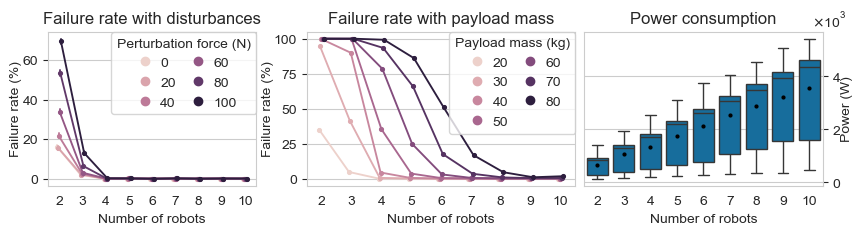

In [57]:
# df_ = df_[df_.force == 0]

fig = plt.figure(figsize=(10, 2))

gs = gridspec.GridSpec(nrows=1, ncols=5, width_ratios=[0.7, -0.01, 0.9, -0.15, 0.8])

# Create subplots using the GridSpec
ax = [plt.subplot(gs[0, 0]), plt.subplot(gs[0, 2]), plt.subplot(gs[0, 4])]

df_ = df.copy()

# randomly select 10% of data
# df_ = df_.sample(frac=0.01)

df_ = df_[

    (df_['policy'] == 'trained_3_torque_joint_force_randomize_weight')
    & (df_['num_cassie'] >= 2)
    & (df_['num_cassie'] <= 10)
    & (df_['terrain'].isin([
        'cassiepede_rectangle',
        'cassiepede_rectangle_30kg_',
        'cassiepede_rectangle_40kg_',
        'cassiepede_rectangle_50kg_',
        'cassiepede_rectangle_60kg_',
        'cassiepede_rectangle_70kg_',
        'cassiepede_rectangle_80kg_',
        # 'cassiepede_rectangle_90kg_',
        # 'cassiepede_rectangle_100kg_',
    ]))

    ]

# df_ = df_[
#     (df_['policy'] == 'trained_3_torque_joint_force_randomize_weight') &
#     (
#         ((df_['num_cassie'] == 2) & (df_['terrain'] == 'cassiepede_rectangle'))
#         | ((df_['num_cassie'] == 3) & (df_['terrain'] == 'cassiepede_rectangle_30kg_'))
#         | ((df_['num_cassie'] == 4) & (df_['terrain'] == 'cassiepede_rectangle_40kg_'))
#         | ((df_['num_cassie'] == 5) & (df_['terrain'] == 'cassiepede_rectangle_50kg_'))
#         | ((df_['num_cassie'] == 6) & (df_['terrain'] == 'cassiepede_rectangle_60kg_'))
#         | ((df_['num_cassie'] == 7) & (df_['terrain'] == 'cassiepede_rectangle_70kg_'))
#         | ((df_['num_cassie'] == 8) & (df_['terrain'] == 'cassiepede_rectangle_80kg_'))
#     )]


terrain_map = {
    'cassiepede_rectangle': 20,
    'cassiepede_rectangle_30kg_': 30,
    'cassiepede_rectangle_40kg_': 40,
    'cassiepede_rectangle_50kg_': 50,
    'cassiepede_rectangle_60kg_': 60,
    'cassiepede_rectangle_70kg_': 70,
    'cassiepede_rectangle_80kg_': 80,
    # 'cassiepede_rectangle_90kg_': 90,
    # 'cassiepede_rectangle_100kg_': 100,
}

df_['payload_mass'] = df_['terrain'].map(terrain_map)
df_.loc[df_.terrain == 'cassiepede_baseline', 'terrain'] = 'cassiepede_rectangle'

df_.loc[(df_['policy'] == 'trained_1') & (df_['num_cassie'] == 1), 'num_cassie'] = '1-R'

df_['failure_rate'] = (df_['episode_length'] < 1000).astype(int) * 100

df_['power'] = df_['power'] / 50 / 20

cmap = sns.set_palette("colorblind")
# cmap = sns.color_palette("light:b", as_cmap=True)
sns.pointplot(data=df_[df_.terrain == 'cassiepede_rectangle'], x='num_cassie', y='failure_rate', hue='force',
              errorbar=('ci', 95),
              palette=cmap,
              ax=ax[0], dodge=True, scale=0.5)

sns.pointplot(data=df_, x='num_cassie', y='failure_rate', hue='payload_mass', errorbar=('ci', 95),
              palette=cmap,
              ax=ax[1], dodge=True, scale=0.5)

sns.boxplot(data=df_[df_.episode_length == 1000], x='num_cassie', y='power', showfliers=False,
            palette=cmap,
            ax=ax[2], showmeans=True,

            meanprops=dict(marker='o', markeredgecolor='black', markersize=2, markerfacecolor='black'),
            # meanline=True,
            )

# sns.pointplot(data=df_[df_.episode_length == 1000], x='num_cassie', y='power', errorbar=('ci', 95),
#              # palette=cmap,
#               color='black',
#               scale=0.5,
#              ax=ax[2], join=False)

ax[0].set_xlabel('Number of robots')
ax[1].set_xlabel('Number of robots')
ax[2].set_xlabel('Number of robots')

ax[0].set_ylabel('Failure rate (%)')
ax[1].set_ylabel('Failure rate (%)')
ax[2].set_ylabel('Power (W)')

# ax[0].legend(ncols=2, title='Perturbation force (N)')
# ax[1].legend(ncols=2, title='Payload mass (kg)')
handles, labels = ax[0].get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([], [], marker='o', linestyle='None', color=handle.get_color())
ax[0].legend(ncols=2, handles=handles, labels=labels, title='Perturbation force (N)', handletextpad=0.1,
             columnspacing=0.6, borderaxespad=0)
handles, labels = ax[1].get_legend_handles_labels()
for i, handle in enumerate(handles):
    handles[i] = plt.Line2D([], [], marker='o', linestyle='None', color=handle.get_color())
ax[1].legend(ncols=2, handles=handles, labels=labels, title='Payload mass (kg)', handletextpad=0.1, columnspacing=0.6,
             borderaxespad=0, )

# sns.move_legend(ax[2], "upper left", ncols=2, title='Perturbation\nForce (N)', bbox_to_anchor=(0.2, 0.99))

# ax[0].yaxis.set_major_formatter(lambda x, pos: f'{x:g}')
# ax[1].yaxis.set_major_formatter(lambda x, pos: f'{x:g}')
# ax[2].yaxis.set_major_formatter(lambda x, pos: f'{x:g}')

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
ax[1].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
ax[2].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
# ax[2].set_xticks(range(2, 11))

ax[0].set_title('Failure rate with disturbances')  #, pad=20)
ax[1].set_title('Failure rate with payload mass')  #, pad=20)
ax[2].set_title('Power consumption')  #, pad=20)

# ax[1].xaxis.label.set_visible(False)
# ax[1].xaxis.label.set_visible(False)
# ax[1].set_yticks([])
# ax[1].set_ylabel('')
ax[2].grid(True, axis='y')
ax[2].grid(False, axis='x')

ax[0].yaxis.tick_left()
ax[1].yaxis.tick_left()
ax[2].yaxis.tick_right()

ax[0].yaxis.set_label_position('left')
ax[1].yaxis.set_label_position('left')
ax[2].yaxis.set_label_position('right')

ax[0].yaxis.labelpad = 0
ax[1].yaxis.labelpad = 0
ax[2].yaxis.labelpad = 0

ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)
ax[2].yaxis.offsetText.set_position((1.1, 0))

# plt.ticklabel_format(axis='both', style='sci', scilimits=(4,4))
# fig.text(0.4, 1.0, 'Failure rate for varying number of robots', ha='center', fontsize=12)
# fig.text(0.8, 1.0, 'Power consumed by all robots combined', ha='center', fontsize=12)

plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.savefig('plot.pdf', dpi=300, bbox_inches='tight')

<Axes: xlabel='num_cassie', ylabel='power'>

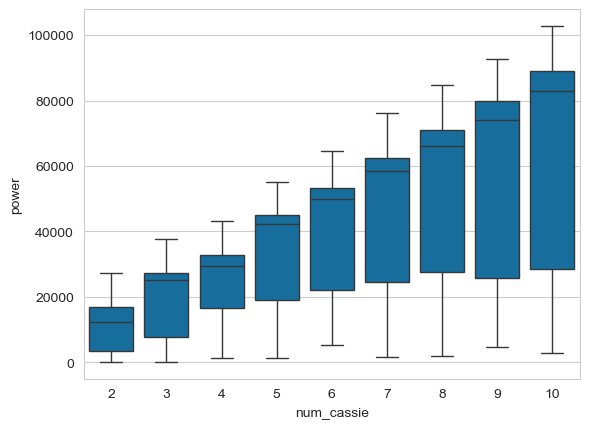

In [91]:
sns.boxplot(data=df_[(df_.episode_length != 100420) & (df_.terrain == 'cassiepede_rectangle')], x='num_cassie',
            y='power', showfliers=False,
            palette=cmap)

In [100]:
df[(df.command_x == 1) & (df.command_y == 0) & (df.command_t == 0) & (df.num_cassie == 5) & (
        df.terrain == 'cassiepede_rectangle') & (df.force == 0)].groupby('policy').size()

,command_h,command_t,command_x,command_y,force,height_diff,height_diff_0,height_diff_1,height_diff_2,height_diff_3,...,odometry_x,odometry_y,odometry_z,poi_linear_acceleration,perturbation_force_bound,orientation_error,run_args,positive_power,robot_positions,poi_positions
0,0.75,15,0,0.0,60,189.524206,189.524206,NaN,NaN,NaN,...,-0.071861,0.072855,-0.243684,10975.300183,"(642, 837)",-0.600066,"{'hidden_dim': 64, 'lstm_hidden_dim': 64, 'lst...",NaN,NaN,NaN
1,0.75,15,0,0.0,60,189.524206,189.524206,NaN,NaN,NaN,...,0.220926,0.333757,-0.215834,11250.199379,"(711, 815)",-0.600066,"{'hidden_dim': 64, 'lstm_hidden_dim': 64, 'lst...",NaN,NaN,NaN
2,0.75,15,0,0.0,60,189.524206,189.524206,NaN,NaN,NaN,...,-1.649033,-0.014628,-0.253043,11342.315559,"(724, 838)",-0.600066,"{'hidden_dim': 64, 'lstm_hidden_dim': 64, 'lst...",NaN,NaN,NaN
3,0.75,15,0,0.0,60,189.524206,189.524206,NaN,NaN,NaN,...,-0.054263,0.122713,-0.257748,10894.103874,"(492, 506)",-0.600066,"{'hidden_dim': 64, 'lstm_hidden_dim': 64, 'lst...",NaN,NaN,NaN
4,0.75,15,0,0.0,60,189.524206,189.524206,NaN,NaN,NaN,...,-0.704848,0.718379,-0.274981,11063.617856,"(800, 996)",-0.600066,"{'hidden_dim': 64, 'lstm_hidden_dim': 64, 'lst...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008995,0.75,15,0,0.0,100,395.377610,47.384837,46.839605,72.196546,67.375287,...,0.032959,0.080593,-0.341098,253.991189,"(611, 862)",-5.194963,"{'hidden_dim': 64, 'lstm_hidden_dim': 64, 'lst...",[440051.85044881 448959.54589646 434287.676653...,[],[]
2008996,0.75,15,0,0.0,100,395.377610,47.384837,46.839605,72.196546,67.375287,...,0.011756,0.083390,-0.342800,379.715086,"(971, 998)",-5.194963,"{'hidden_dim': 64, 'lstm_hidden_dim': 64, 'lst...",[440051.85044881 448959.54589646 434287.676653...,[],[]
2008997,0.75,15,0,0.0,100,395.377610,47.384837,46.839605,72.196546,67.375287,...,0.034708,0.105367,-0.350929,311.011967,"(152, 488)",-5.194963,"{'hidden_dim': 64, 'lstm_hidden_dim': 64, 'lst...",[440051.85044881 448959.54589646 434287.676653...,[],[]
2008998,0.75,15,0,0.0,100,395.377610,47.384837,46.839605,72.196546,67.375287,...,0.033171,0.069169,-0.322763,296.315040,"(108, 554)",-5.194963,"{'hidden_dim': 64, 'lstm_hidden_dim': 64, 'lst...",[440051.85044881 448959.54589646 434287.676653...,[],[]
